In [0]:
%pip install azure-storage-blob

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
from azure.storage.blob import BlobServiceClient
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Initialize Spark session
spark = SparkSession.builder.appName("NYCTaxiEmissionAnalysis").getOrCreate()

# Azure Blob Storage configuration
storage_account_name = "datastorage4zims"
storage_account_key = "RZswKvPTf1D45dEOu1mBDMi206vsDxw0eGRvgT9/kwfTSLoNFx+jMa36pwumSubp7J0Z0Wa/no/i+ASt83SUGQ=="
container_name = "nyc-taxilimousine-commission"

spark.conf.set(f"fs.azure.account.key.{storage_account_name}.blob.core.windows.net", storage_account_key)

blob_service_client = BlobServiceClient(account_url=f"https://{storage_account_name}.blob.core.windows.net", credential=storage_account_key)

In [0]:
# Function to list all files in the container
def list_files(container_name):
    container_client = blob_service_client.get_container_client(container_name)
    blob_list = container_client.list_blobs()
    return [blob.name for blob in blob_list]

In [0]:
dataframes_list = []

for blob_name in list_files(container_name):
    file_path = f"wasbs://{container_name}@{storage_account_name}.blob.core.windows.net/{blob_name}"
    print(f"Processing file: {blob_name}")
    
    # Load data from Parquet file
    df = spark.read.parquet(file_path)
    
    # Append the DataFrame to the list
    dataframes_list.append(df)

Processing file: yellow_tripdata_2023-01.parquet
Processing file: yellow_tripdata_2023-02.parquet
Processing file: yellow_tripdata_2023-03.parquet
Processing file: yellow_tripdata_2023-04.parquet
Processing file: yellow_tripdata_2023-05.parquet
Processing file: yellow_tripdata_2023-06.parquet
Processing file: yellow_tripdata_2023-07.parquet
Processing file: yellow_tripdata_2023-08.parquet
Processing file: yellow_tripdata_2023-09.parquet
Processing file: yellow_tripdata_2023-10.parquet
Processing file: yellow_tripdata_2023-11.parquet
Processing file: yellow_tripdata_2023-12.parquet


In [0]:
# Merge all DataFrames into a single DataFrame
if dataframes_list:
    merged_df = dataframes_list[0]
    for df in dataframes_list[1:]:
        merged_df = merged_df.union(df)

# Save the merged DataFrame as a permanent table with schema merging enabled
merged_df.write.option("mergeSchema", "true").mode("overwrite").saveAsTable("Taxi_emission_2023_official")
print("All files processed and merged into 'Taxi_emission_2023_official' table.")

All files processed and merged into 'Taxi_emission_2023_official' table.


In [0]:
%sql
SELECT * FROM Taxi_emission_2023_official

VendorID tpep_pickup_datetime tpep_dropoff_datetime passenger_count trip_distance RatecodeID store_and_fwd_flag PULocationID DOLocationID payment_type fare_amount extra mta_tax tip_amount tolls_amount improvement_surcharge total_amount congestion_surcharge airport_fee 1 2023-07-01T00:29:59 2023-07-01T00:40:15 1.0 1.8 1.0 N 140 263 1 12.1 3.5 0.5 5.1 0.0 1.0 22.2 2.5 0.0 2 2023-07-01T00:03:25 2023-07-01T00:23:44 1.0 2.31 1.0 N 163 163 2 19.1 1.0 0.5 0.0 0.0 1.0 24.1 2.5 0.0 2 2023-07-01T00:38:29 2023-07-01T00:48:53 1.0 2.36 1.0 N 142 262 1 13.5 1.0 0.5 3.7 0.0 1.0 22.2 2.5 0.0 2 2023-07-01T00:14:16 2023-07-01T00:29:13 1.0 4.36 1.0 N 68 24 1 19.8 1.0 0.5 4.96 0.0 1.0 29.76 2.5 0.0 1 2023-07-01T00:11:15 2023-07-01T00:20:47 0.0 1.6 1.0 N 161 107 1 11.4 3.5 0.5 3.25 0.0 1.0 19.65 2.5 0.0 2 2023-07-01T00:29:32 2023-07-01T00:54:14 1.0 8.67 1.0 N 138 186 1 38.7 6.0 0.5 7.0 6.55 1.0 64.0 2.5 1.75 2 2023-07-01T00:24:43 2023-07-01T00:47:49 1.0 9.11 1.0 N 138 230 1 39.4 6.0 0.5 11.19 6.55 1.0 68.89 2.5 1.75 2 2023-07-01T00:35:28 2023-07-01T00:45:30 1.0 3.08 1.0 N 166 244 1 14.9 1.0 0.5 3.48 0.0 1.0 20.88 0.0 0.0 1 2023-07-01T00:31:05 2023-07-01T00:35:20 0.0 1.1 1.0 N 138 70 1 7.9 7.75 0.5 3.4 0.0 1.0 20.55 0.0 1.75 2 2023-07-01T00:38:00 2023-07-01T00:54:47 3.0 3.88 1.0 N 186 24 1 19.8 1.0 0.5 1.0 0.0 1.0 25.8 2.5 0.0 1 2023-07-01T00:02:08 2023-07-01T00:19:00 1.0 8.1 1.0 N 95 7 1 33.8 1.0 0.5 5.0 0.0 1.0 41.3 0.0 0.0 2 2023-07-01T00:28:22 2023-07-01T00:50:41 1.0 5.33 1.0 N 158 236 1 25.4 1.0 0.5 6.08 0.0 1.0 36.48 2.5 0.0 1 2023-07-01T00:08:26 2023-07-01T00:32:55 2.0 2.1 1.0 N 142 142 2 21.9 3.5 0.5 0.0 0.0 1.0 26.9 2.5 0.0 1 2023-07-01T00:43:13 2023-07-01T00:53:54 1.0 2.4 1.0 N 142 68 1 13.5 3.5 0.5 3.7 0.0 1.0 22.2 2.5 0.0 2 2023-07-01T00:05:07 2023-07-01T00:10:03 1.0 1.2 1.0 N 170 107 1 7.9 1.0 0.5 0.0 0.0 1.0 12.9 2.5 0.0 2 2023-07-01T00:29:24 2023-07-01T00:35:35 1.0 0.81 1.0 N 68 249 1 7.2 1.0 0.5 2.44 0.0 1.0 14.64 2.5 0.0 2 2023-07-01T00:55:31 2023-07-01T01:03:02 1.0 1.32 1.0 N 170 161 2 9.3 1.0 0.5 0.0 0.0 1.0 14.3 2.5 0.0 1 2023-07-01T00:02:32 2023-07-01T00:09:44 2.0 0.9 1.0 N 142 230 1 8.6 3.5 0.5 2.7 0.0 1.0 16.3 2.5 0.0 1 2023-07-01T00:12:01 2023-07-01T00:16:54 2.0 0.5 1.0 N 249 158 1 5.1 3.5 0.5 2.0 0.0 1.0 12.1 2.5 0.0 1 2023-07-01T00:20:37 2023-07-01T00:27:03 2.0 1.0 1.0 N 158 234 1 7.9 3.5 0.5 2.55 0.0 1.0 15.45 2.5 0.0 1 2023-07-01T00:30:18 2023-07-01T00:49:29 2.0 4.0 1.0 N 186 145 1 21.2 3.5 0.5 5.2 0.0 1.0 31.4 2.5 0.0 2 2023-07-01T00:08:30 2023-07-01T00:21:20 1.0 2.25 1.0 N 230 90 1 13.5 1.0 0.5 3.7 0.0 1.0 22.2 2.5 0.0 1 2023-07-01T00:58:26 2023-07-01T01:02:45 2.0 1.2 1.0 N 137 229 1 7.2 3.5 0.5 2.0 0.0 1.0 14.2 2.5 0.0 2 2023-07-01T00:04:57 2023-07-01T00:33:13 1.0 11.86 1.0 N 138 48 1 49.9 6.0 0.5 5.0 6.55 1.0 73.2 2.5 1.75 2 2023-07-01T00:08:38 2023-07-01T00:14:48 1.0 0.9 1.0 N 113 90 1 7.9 1.0 0.5 2.58 0.0 1.0 15.48 2.5 0.0 2 2023-07-01T00:24:35 2023-07-01T00:37:27 1.0 2.27 1.0 N 90 144 1 13.5 1.0 0.5 2.0 0.0 1.0 20.5 2.5 0.0 2 2023-07-01T00:05:28 2023-07-01T00:11:53 1.0 0.84 1.0 N 246 48 2 7.9 1.0 0.5 0.0 0.0 1.0 12.9 2.5 0.0 2 2023-07-01T00:31:12 2023-07-01T00:43:29 1.0 2.72 1.0 N 68 229 1 14.9 1.0 0.5 1.18 0.0 1.0 21.08 2.5 0.0 2 2023-07-01T00:56:44 2023-07-01T01:07:57 1.0 2.95 1.0 N 162 7 1 16.3 1.0 0.5 0.0 0.0 1.0 21.3 2.5 0.0 2 2023-06-30T23:59:27 2023-07-01T00:06:08 1.0 1.35 1.0 N 144 158 1 9.3 1.0 0.5 2.0 0.0 1.0 16.3 2.5 0.0 2 2023-07-01T00:07:32 2023-07-01T00:15:35 1.0 1.46 1.0 N 158 246 1 10.0 1.0 0.5 3.0 0.0 1.0 18.0 2.5 0.0 2 2023-07-01T00:38:11 2023-07-01T00:54:19 1.0 2.71 1.0 N 249 233 1 17.0 1.0 0.5 4.4 0.0 1.0 26.4 2.5 0.0 2 2023-07-01T00:20:35 2023-07-01T00:43:34 1.0 11.81 1.0 N 70 126 1 46.4 6.0 0.5 5.0 0.0 1.0 60.65 0.0 1.75 2 2023-07-01T00:43:26 2023-07-01T00:50:18 1.0 0.92 1.0 N 249 79 1 7.9 1.0 0.5 2.58 0.0 1.0 15.48 2.5 0.0 2 2023-07-01T00:08:30 2023-07-01T00:18:38 1.0 1.31 1.0 N 163 143 1 10.7 1.0 0.5 3.14 0.0 1.0 18.84 2.5 0.0 2 2023-07-01T00:36:35 2023-07-01T00:42:23 1.0 1.13 1.0 N 142 229

In [0]:
%sql
SELECT 
    tpep_pickup_datetime AS trip_date,
    passenger_count,
    trip_distance,
    (trip_distance / 22) AS fuel_consumed_gallons,
    (trip_distance / 22) * 8.89 AS co2_emissions_kg
FROM 
    Taxi_emission_2023_official
WHERE 
    passenger_count IS NOT NULL
ORDER BY 
    trip_date;

trip_date passenger_count trip_distance fuel_consumed_gallons co2_emissions_kg 2001-01-01T00:06:49 2.0 7.41 0.33681818181818185 2.994313636363637 2001-01-01T00:07:36 1.0 1.68 0.07636363636363636 0.6788727272727273 2001-01-01T00:08:31 1.0 18.63 0.8468181818181818 7.5282136363636365 2001-01-01T00:08:42 1.0 17.68 0.8036363636363636 7.144327272727272 2001-01-01T00:28:40 1.0 10.23 0.465 4.133850000000001 2001-01-01T15:18:51 2.0 9.13 0.41500000000000004 3.6893500000000006 2002-12-31T22:16:54 1.0 3.25 0.14772727272727273 1.3132954545454547 2002-12-31T22:27:05 1.0 11.77 0.535 4.756150000000001 2002-12-31T23:03:18 1.0 28.19 1.2813636363636365 11.39132272727273 2002-12-31T23:03:19 1.0 18.13 0.8240909090909091 7.326168181818183 2002-12-31T23:05:19 1.0 0.0 0.0 0.0 2002-12-31T23:05:43 1.0 15.73 0.715 6.35635 2002-12-31T23:10:19 1.0 6.96 0.31636363636363635 2.8124727272727275 2002-12-31T23:18:49 1.0 3.03 0.13772727272727273 1.2243954545454545 2002-12-31T23:28:55 1.0 0.98 0.04454545454545455 0.396009090909091 2002-12-31T23:33:00 1.0 17.54 0.7972727272727272 7.087754545454546 2002-12-31T23:41:25 1.0 20.57 0.935 8.31215 2003-01-01T00:03:31 1.0 2.81 0.12772727272727272 1.1354954545454545 2003-01-01T00:04:45 1.0 18.19 0.8268181818181819 7.350413636363638 2003-01-01T00:06:44 1.0 3.45 0.15681818181818183 1.3941136363636366 2003-01-01T00:07:18 1.0 31.43 1.4286363636363637 12.700577272727275 2003-01-01T00:07:27 1.0 20.12 0.9145454545454546 8.130309090909092 2003-01-01T00:48:43 3.0 3.29 0.14954545454545454 1.3294590909090909 2008-12-31T10:34:59 1.0 3.01 0.1368181818181818 1.2163136363636364 2008-12-31T13:14:17 1.0 19.37 0.8804545454545455 7.82724090909091 2008-12-31T14:08:58 1.0 8.41 0.38227272727272726 3.3984045454545457 2008-12-31T15:05:04 1.0 11.77 0.535 4.756150000000001 2008-12-31T17:36:33 1.0 8.52 0.38727272727272727 3.4428545454545456 2008-12-31T20:41:22 1.0 6.46 0.29363636363636364 2.610427272727273 2008-12-31T23:01:42 1.0 1.93 0.08772727272727272 0.7798954545454546 2008-12-31T23:01:42 1.0 17.76 0.8072727272727274 7.1766545454545465 2008-12-31T23:03:12 1.0 1.43 0.065 0.5778500000000001 2008-12-31T23:04:24 1.0 1.37 0.06227272727272728 0.5536045454545455 2008-12-31T23:04:41 1.0 0.0 0.0 0.0 2008-12-31T23:04:45 1.0 16.66 0.7572727272727273 6.732154545454546 2008-12-31T23:05:06 1.0 3.04 0.13818181818181818 1.2284363636363638 2008-12-31T23:05:58 1.0 13.61 0.6186363636363637 5.499677272727273 2008-12-31T23:06:15 1.0 0.59 0.026818181818181817 0.23841363636363638 2008-12-31T23:06:21 1.0 10.13 0.4604545454545455 4.093440909090909 2008-12-31T23:06:48 1.0 12.13 0.5513636363636364 4.901622727272728 2008-12-31T23:07:01 1.0 18.69 0.8495454545454546 7.552459090909092 2008-12-31T23:11:10 1.0 2.95 0.1340909090909091 1.192068181818182 2008-12-31T23:13:18 1.0 5.12 0.23272727272727273 2.068945454545455 2008-12-31T23:28:38 1.0 4.61 0.20954545454545456 1.8628590909090912 2008-12-31T23:34:45 1.0 11.32 0.5145454545454545 4.574309090909091 2008-12-31T23:43:40 1.0 1.66 0.07545454545454545 0.6707909090909091 2009-01-01T00:02:25 1.0 2.67 0.12136363636363635 1.0789227272727273 2009-01-01T00:02:41 1.0 1.37 0.06227272727272728 0.5536045454545455 2009-01-01T00:02:43 1.0 0.0 0.0 0.0 2009-01-01T00:02:43 1.0 0.0 0.0 0.0 2009-01-01T00:04:41 1.0 2.26 0.10272727272727272 0.9132454545454546 2009-01-01T00:05:00 1.0 1.58 0.07181818181818182 0.6384636363636365 2009-01-01T00:05:04 3.0 0.33 0.015000000000000001 0.13335000000000002 2009-01-01T00:05:14 1.0 1.92 0.08727272727272727 0.7758545454545455 2009-01-01T00:06:35 5.0 4.48 0.20363636363636364 1.810327272727273 2009-01-01T04:36:53 1.0 21.4 0.9727272727272727 8.647545454545455 2009-01-01T05:56:45 1.0 1.91 0.08681818181818181 0.7718136363636363 2009-01-01T07:07:04 1.0 3.07 0.13954545454545453 1.240559090909091 2009-01-01T15:33:49 1.0 1.13 0.05136363636363636 0.4566227272727273 2009-01-01T20:07:44 1.0 0.0 0.0 0.0 2009-01-01T23:54:03 1.0 0.0 0.0 0.0 2014-11-19T08:18:40 2.0 6.43 0.29227272727272724 2.5983045454545453 2022-10-24T17:37:47 1.

In [0]:
%sql
SELECT
    DATE_FORMAT(tpep_pickup_datetime, 'd MMM, yyyy') AS trip_date,
    CASE 
        WHEN passenger_count <= 2 THEN '1-2 Passengers'
        ELSE '3+ Passengers'
    END AS passenger_group,
    SUM((trip_distance / 22) * 8.89) AS total_co2_emissions_kg
FROM
    Taxi_emission_2023_official
WHERE
    passenger_count IS NOT NULL
    AND YEAR(tpep_pickup_datetime) = 2023
GROUP BY
    trip_date,
    CASE 
        WHEN passenger_count <= 2 THEN '1-2 Passengers'
        ELSE '3+ Passengers'
    END
ORDER BY
    trip_date, passenger_group;

trip_date passenger_group total_co2_emissions_kg 1 Apr, 2023 1-2 Passengers 132954.071727279 1 Apr, 2023 3+ Passengers 18336.46550909083 1 Aug, 2023 1-2 Passengers 123624.5339636424 1 Aug, 2023 3+ Passengers 12781.924813636284 1 Dec, 2023 1-2 Passengers 153659.59292728448 1 Dec, 2023 3+ Passengers 13886.474986363583 1 Feb, 2023 1-2 Passengers 120381.74886819045 1 Feb, 2023 3+ Passengers 8335.651927272742 1 Jan, 2023 1-2 Passengers 133877.43561818576 1 Jan, 2023 3+ Passengers 18266.521413636212 1 Jul, 2023 1-2 Passengers 102234.97575454932 1 Jul, 2023 3+ Passengers 14934.844399999927 1 Jun, 2023 1-2 Passengers 151266.55444092126 1 Jun, 2023 3+ Passengers 13196.10587272722 1 Mar, 2023 1-2 Passengers 137289.02160909912 1 Mar, 2023 3+ Passengers 9938.175449999952 1 May, 2023 1-2 Passengers 145712.36934546145 1 May, 2023 3+ Passengers 11306.572740909083 1 Nov, 2023 1-2 Passengers 143671.70621364616 1 Nov, 2023 3+ Passengers 11456.203563636402 1 Oct, 2023 1-2 Passengers 141506.1264590966 1 Oct, 2023 3+ Passengers 13211.489613636279 1 Sep, 2023 1-2 Passengers 126503.87969546033 1 Sep, 2023 3+ Passengers 14443.429445454485 10 Apr, 2023 1-2 Passengers 122334.6434545505 10 Apr, 2023 3+ Passengers 15048.143409090879 10 Aug, 2023 1-2 Passengers 130360.29300000839 10 Aug, 2023 3+ Passengers 12990.99336818176 10 Dec, 2023 1-2 Passengers 132010.75382727844 10 Dec, 2023 3+ Passengers 14226.242704545333 10 Feb, 2023 1-2 Passengers 141523.54681819078 10 Feb, 2023 3+ Passengers 11245.700486363625 10 Jan, 2023 1-2 Passengers 116622.81037273437 10 Jan, 2023 3+ Passengers 8618.786304545427 10 Jul, 2023 1-2 Passengers 132662.1241272783 10 Jul, 2023 3+ Passengers 12955.76068181813 10 Jun, 2023 1-2 Passengers 130630.85206818786 10 Jun, 2023 3+ Passengers 14842.105536363599 10 Mar, 2023 1-2 Passengers 148921.69975455652 10 Mar, 2023 3+ Passengers 12486.986940909032 10 May, 2023 1-2 Passengers 163106.3413000089 10 May, 2023 3+ Passengers 10380.032695454496 10 Nov, 2023 1-2 Passengers 148295.53260455697 10 Nov, 2023 3+ Passengers 12599.433318181747 10 Oct, 2023 1-2 Passengers 146049.7650500079 10 Oct, 2023 3+ Passengers 11263.642122727186 10 Sep, 2023 1-2 Passengers 141288.63260909717 10 Sep, 2023 3+ Passengers 12854.27729090908 11 Apr, 2023 1-2 Passengers 132772.89756818823 11 Apr, 2023 3+ Passengers 14324.10544090903 11 Aug, 2023 1-2 Passengers 116018.34290455029 11 Aug, 2023 3+ Passengers 14685.791049999896 11 Dec, 2023 1-2 Passengers 134543.86234546412 11 Dec, 2023 3+ Passengers 11218.181895454492 11 Feb, 2023 1-2 Passengers 130305.99530455365 11 Feb, 2023 3+ Passengers 13566.754218181673 11 Jan, 2023 1-2 Passengers 121400.96716364169 11 Jan, 2023 3+ Passengers 9073.10571363635 11 Jul, 2023 1-2 Passengers 134166.9021000077 11 Jul, 2023 3+ Passengers 13264.255804545439 11 Jun, 2023 1-2 Passengers 144758.69055455193 11 Jun, 2023 3+ Passengers 15136.962590909057 11 Mar, 2023 1-2 Passengers 124450.37051364339 11 Mar, 2023 3+ Passengers 13647.96032727268 11 May, 2023 1-2 Passengers 164006.94275001172 11 May, 2023 3+ Passengers 11447.018577272689 11 Nov, 2023 1-2 Passengers 132972.39725000763 11 Nov, 2023 3+ Passengers 12914.535327272646 11 Oct, 2023 1-2 Passengers 147817.1051318268 11 Oct, 2023 3+ Passengers 10652.604136363609 11 Sep, 2023 1-2 Passengers 169383.1258000122 11 Sep, 2023 3+ Passengers 10235.610604545407 12 Apr, 2023 1-2 Passengers 136172.57904091635 12 Apr, 2023 3+ Passengers 14381.914686363536 12 Aug, 2023 1-2 Passengers 108508.09110909463 12 Aug, 2023 3+ Passengers 15494.995218181704 12 Dec, 2023 1-2 Passengers 142436.75994546514 12 Dec, 2023 3+ Passengers 10016.59333181813 12 Feb, 2023 1-2 Passengers 124980.20643182252 12 Feb, 2023 3+ Passengers 11395.036322727265 12 Jan, 2023 1-2 Passengers 145373.4583000064 12 Jan, 2023 3+ Passengers 10262.308890909062 12 Jul, 2023 1-2 Passengers 136133.94795000704 12 Jul, 2023 3+ Passengers 13371.384345454539 12 Jun, 2023 1-2 Passengers 148249.48240455418 12 Jun, 2023 3+ Passengers 12635.385286363571 1

In [0]:
# First, let's assign the SQL query results to a DataFrame variable
emissions_df = spark.sql("""
    SELECT
        DATE_FORMAT(tpep_pickup_datetime, 'd MMM, yyyy') AS trip_date,
        CASE 
            WHEN passenger_count <= 2 THEN '1-2 Passengers'
            ELSE '3+ Passengers'
        END AS passenger_group,
        SUM((trip_distance / 22) * 8.89) AS total_co2_emissions_kg
    FROM
        Taxi_emission_2023_official
    WHERE
        passenger_count IS NOT NULL
        AND YEAR(tpep_pickup_datetime) = 2023
    GROUP BY
        trip_date,
        CASE 
            WHEN passenger_count <= 2 THEN '1-2 Passengers'
            ELSE '3+ Passengers'
        END
    ORDER BY
        trip_date, passenger_group;
""")
emissions_df.write.option("mergeSchema", "true").mode("overwrite").saveAsTable("Emission_perday_2023")

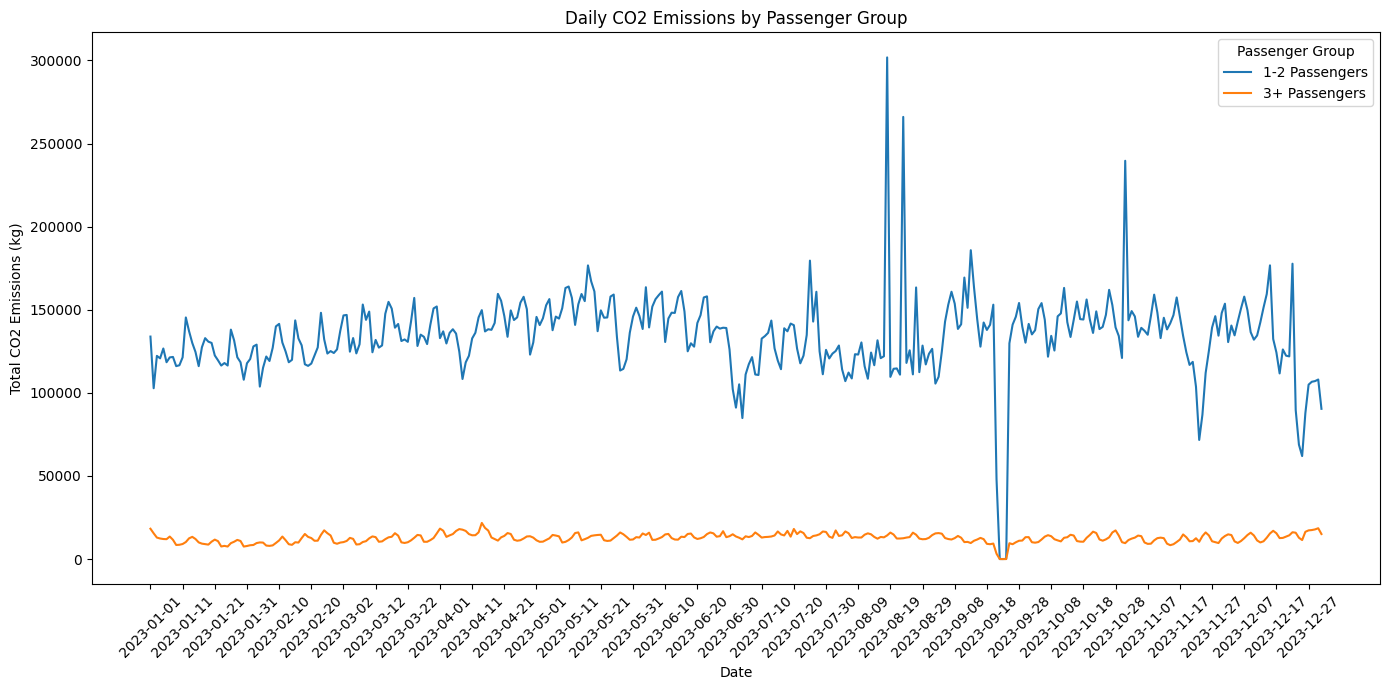

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `daily_emissions_df` is a DataFrame holding the result from the SQL query
# Load your data into a DataFrame
daily_emissions_df = spark.sql("SELECT * FROM Emission_perday_2023").toPandas()  # Replace with your SQL temp view or DataFrame name

# Convert `trip_date` to datetime format and sort by date
daily_emissions_df['trip_date'] = pd.to_datetime(daily_emissions_df['trip_date'])
daily_emissions_df = daily_emissions_df.sort_values('trip_date')

# Pivot the data for easy plotting
pivot_df = daily_emissions_df.pivot(index='trip_date', columns='passenger_group', values='total_co2_emissions_kg')
pivot_df.fillna(0, inplace=True)

# Plot each passenger group as a separate line
plt.figure(figsize=(14, 7))
for passenger_group in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[passenger_group], label=passenger_group)

# Customize plot
plt.xlabel('Date')
plt.ylabel('Total CO2 Emissions (kg)')
plt.title('Daily CO2 Emissions by Passenger Group')
plt.legend(title='Passenger Group')

# Adjust x-axis tick labels
plt.xticks(pivot_df.index[::10], rotation=45)  # Display every 10th date label, adjust this number as needed

plt.tight_layout()
plt.show()